In [24]:
import json
import numpy as np
import pandas as pd
from os import path
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import MeCab

In [25]:
stories_json = []
with open('./output_storiesv2.json', 'r') as f:
    stories_json = stories_json + json.loads(f.read())

print(len(stories_json))
print(stories_json[1].keys())

407
dict_keys(['index', 'title', 'broadcasting_date', 'abstracts_list'])


In [26]:
stories_df = pd.DataFrame(stories_json)
stories_df = stories_df.explode('abstracts_list')
stories_df.rename(columns={'abstracts_list': 'abstract'}, inplace=True)

print(len(stories_df))

822


In [27]:
stories_df['broadcasting_date'] = stories_df['broadcasting_date'].apply(lambda d: datetime.strptime(d, '%Y年%m月%d日'))

In [28]:
t = MeCab.Tagger('-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')
def mecab_tokenizer(text):
    parsed_lines = t.parse(text).split("\n")[:-2]
    surfaces = [l.split('\t')[0] for l in parsed_lines]
    features = [l.split('\t')[1] for l in parsed_lines]
    # 原型を取得
    bases = [f.split(',')[6] for f in features]
    # 品詞を取得
    pos = [f.split(',')[0] for f in features]

    # 各単語を原型に変換する
    token_list = [b if b != '*' else s for s, b in zip(surfaces, bases)]
    # 瀕死を絞り込み
    target_pos = ["名詞"]
    token_list = [t for t, p in zip(token_list, pos) if p in target_pos]
    # アルファベットを小文字に統一
    token_list = [t.lower() for t in token_list]

    return [ text for text in filter(lambda x: not x.isascii(), token_list)]

In [29]:
# ストーリーが取得できたものに絞る
stories_df = stories_df[stories_df['abstract'].str.len() > 0] 
stories_df['abstracts_tokenize'] = stories_df['abstract'].apply(mecab_tokenizer)
stories_df.head()

,index,title,broadcasting_date,abstract,abstracts_tokenize
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,2013-03-15,何をやってもうまくいかないのび太は、「魔法（まほう）が使えたら便利で楽しくなるにちがいない...,"[何, のび太, 魔法, 魔法, 便利, ちがい, もしもボックス, 現実, 世界, 魔法,..."
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,2013-03-15,★最新作『映画ドラえもん のび太のひみつ道具博物館（ミュージアム）』の寺本幸代監督が、初めて...,"[最新作, 映画ドラえもん, のび太のひみつ道具博物館, ミュージアム, 寺本幸代, 監督,..."
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],2013-04-12,ある朝、ねぼうしたのび太に泣きつかれたドラえもんは、『ばくはつコショウ』を取り出す。このコ...,"[朝, 寝坊, のび太, ドラえもん, 爆発, コショウ, コショウ, 行き先, そば, 人..."
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],2013-04-12,みんなから家族でお花見に行った話を聞き、うらやましくてしかたのないのび太。さっそくママにた...,"[みんな, 家族, お花見, 話, しかた, のび太, ママ, パパ, ゴルフ, 予定, の..."
2,0327,「やりクリしてハワイ旅行」「しずかちゃんのはごろも」[2013年4月26日放送],2013-04-26,スネ夫からハワイ旅行をじまんされたのび太は、自分もハワイに行きたいとママにたのもうとするが...,"[スネ夫, ハワイ旅行, じまん, のび太, 自分, ハワイ, ママ, 給料日, 前, お金..."


In [30]:
stories_df["doraemon_count"] = stories_df["abstracts_tokenize"].apply(lambda x: x.count("ドラえもん"))
stories_df["nobita_count"] = stories_df["abstracts_tokenize"].apply(lambda x: x.count("のび太"))
stories_df["sizuka_count"] = stories_df["abstracts_tokenize"].apply(lambda x: x.count("しずか"))
stories_df["gian_count"] = stories_df["abstracts_tokenize"].apply(lambda x: x.count("ジャイアン"))
stories_df["suneo_count"] = stories_df["abstracts_tokenize"].apply(lambda x: x.count("スネ夫"))
stories_df["dekisugi_count"] = stories_df["abstracts_tokenize"].apply(lambda x: x.count("出木杉"))
stories_df["dorami_count"] = stories_df["abstracts_tokenize"].apply(lambda x: x.count("ドラミ"))
stories_df["jaiko_count"] = stories_df["abstracts_tokenize"].apply(lambda x: x.count("ジャイ子"))

stories_df.keys()

Index(['index', 'title', 'broadcasting_date', 'abstract', 'abstracts_tokenize',
       'doraemon_count', 'nobita_count', 'sizuka_count', 'gian_count',
       'suneo_count', 'dekisugi_count', 'dorami_count', 'jaiko_count'],
      dtype='object')

In [31]:
stories_df['broadcasting_quarter'] = pd.PeriodIndex(stories_df['broadcasting_date'], freq='Q')
stories_df.head()

,index,title,broadcasting_date,abstract,abstracts_tokenize,doraemon_count,nobita_count,sizuka_count,gian_count,suneo_count,dekisugi_count,dorami_count,jaiko_count,broadcasting_quarter
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,2013-03-15,何をやってもうまくいかないのび太は、「魔法（まほう）が使えたら便利で楽しくなるにちがいない...,"[何, のび太, 魔法, 魔法, 便利, ちがい, もしもボックス, 現実, 世界, 魔法,...",2,5,1,1,1,0,0,0,2013Q1
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,2013-03-15,★最新作『映画ドラえもん のび太のひみつ道具博物館（ミュージアム）』の寺本幸代監督が、初めて...,"[最新作, 映画ドラえもん, のび太のひみつ道具博物館, ミュージアム, 寺本幸代, 監督,...",0,0,0,0,0,0,0,0,2013Q1
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],2013-04-12,ある朝、ねぼうしたのび太に泣きつかれたドラえもんは、『ばくはつコショウ』を取り出す。このコ...,"[朝, 寝坊, のび太, ドラえもん, 爆発, コショウ, コショウ, 行き先, そば, 人...",2,3,0,2,0,0,0,0,2013Q2
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],2013-04-12,みんなから家族でお花見に行った話を聞き、うらやましくてしかたのないのび太。さっそくママにた...,"[みんな, 家族, お花見, 話, しかた, のび太, ママ, パパ, ゴルフ, 予定, の...",1,3,1,0,0,0,0,0,2013Q2
2,0327,「やりクリしてハワイ旅行」「しずかちゃんのはごろも」[2013年4月26日放送],2013-04-26,スネ夫からハワイ旅行をじまんされたのび太は、自分もハワイに行きたいとママにたのもうとするが...,"[スネ夫, ハワイ旅行, じまん, のび太, 自分, ハワイ, ママ, 給料日, 前, お金...",1,3,0,0,1,0,0,0,2013Q2


In [32]:
grouped_df = stories_df.groupby([stories_df['broadcasting_quarter']]).sum()
grouped_df.reset_index(inplace=True)
melt_df = pd.melt(
    grouped_df,
    id_vars=['broadcasting_quarter'],
    value_vars=['doraemon_count', 'nobita_count', 'sizuka_count', 'gian_count', 'suneo_count', 'dekisugi_count', "dorami_count", "jaiko_count"]
)
melt_df.head()

,broadcasting_quarter,variable,value
0,2013Q1,doraemon_count,2
1,2013Q2,doraemon_count,40
2,2013Q3,doraemon_count,42
3,2013Q4,doraemon_count,49
4,2014Q1,doraemon_count,32


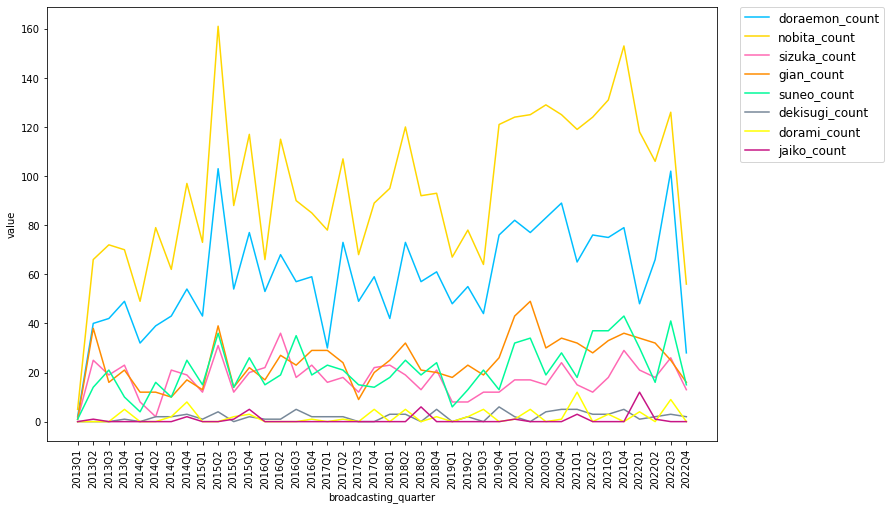

In [33]:
colors = ['#00bfff', '#ffd700', '#ff69b4', '#ff8c00', '#00fa9a', '#778899', '#ffff00', '#c71585']

plt.figure(figsize=(12,8))
sns.lineplot(x=melt_df['broadcasting_quarter'].astype(str), y=melt_df['value'], hue=melt_df['variable'], palette=sns.color_palette(colors))
plt.legend(bbox_to_anchor=(1.25, 1.0), loc='upper right', borderaxespad=0, fontsize=12)
plt.tick_params(axis='x', labelrotation=90)
